In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from scipy.linalg import pinv
from sklearn.metrics import classification_report
from scipy.linalg import svd
from scipy.sparse.linalg import svds


In [10]:
dataset = pd.read_csv('../Datasets/data_with_normalization.csv') # Data already normalized pre-midsem.

# Removing the non-numerical columns
dataset = dataset.drop(columns=['URL', 'Domain', 'Title'])
dataset.head()

,URLLength,DomainLength,IsDomainIP,TLD,TLDLength,NoOfSubDomain,NoOfLettersInURL,NoOfDegitsInURL,NoOfEqualsInURL,NoOfQMarkInURL,...,NoOfiFrame,HasExternalFormSubmit,HasHiddenFields,HasPasswordField,Bank,Pay,Crypto,NoOfCSS,NoOfEmptyRef,label
0,-0.891300,-1.437329,0,191,-1.449374,-1.934269,-0.789202,0.119473,-0.119462,-0.146444,...,-0.346864,0,0,0,0,0,0,-0.519592,-0.292089,0
1,0.019356,0.603674,0,179,0.524801,-0.250327,0.196725,-0.356586,-0.119462,-0.146444,...,-0.346864,0,0,0,0,0,0,-0.519592,-0.292089,0
2,0.360852,1.113925,0,179,0.524801,-0.250327,0.126302,1.071590,-0.119462,-0.146444,...,-0.346864,0,1,0,1,1,0,-0.225707,-0.292089,0
3,0.360852,1.241488,0,112,0.524801,-0.250327,0.619265,-0.356586,-0.119462,-0.146444,...,-0.346864,0,0,0,0,0,0,-0.519592,-0.292089,0
4,-0.549804,-0.671953,0,179,0.524801,1.433615,-0.648355,-0.118556,-0.119462,-0.146444,...,-0.346864,0,0,0,0,0,0,-0.519592,-0.292089,0


In [11]:
feature_vars = dataset.columns.to_list()
feature_vars.remove('label')
target_var = 'label'

X = dataset[feature_vars].to_numpy()
Y = dataset[target_var].to_numpy()

# Splitting into Train and Test
X_Train, X_Test, Y_Train, Y_Test = train_test_split(X, Y, test_size = 0.3, random_state = 42, stratify = Y)

In [12]:

def compute_leverage_scores(X, k):
    U, _, _ = svds(X, k=k)
    leverage_scores = np.sum(U**2, axis=1) # row norms
    return leverage_scores


def sample_columns(X, leverage_scores, k, random_state=42):
    np.random.seed(random_state)
    n_cols = X.shape[1]
    prob = leverage_scores / np.sum(leverage_scores)
    selected_columns = np.random.choice(n_cols, size=k, replace=False, p=prob)
    return X[:, selected_columns], selected_columns


def cur_decomposition(X, k):
    leverage_scores = compute_leverage_scores(X.T, k)
    C, selected_columns = sample_columns(X, leverage_scores, k) # sampling k columns based on leverage_scores
    U = np.linalg.pinv(C.T @ C) @ (C.T @ X)  
    return C, U, selected_columns

In [13]:
k = 15  # Target dimensionality
C_train, U_train, selected_columns = cur_decomposition(X_Train, k)


X_Train_reduced = X_Train[:, selected_columns]
X_Test_reduced = X_Test[:, selected_columns]

print(f"Reduced Training Shape: {X_Train_reduced.shape}")
print(f"Reduced Testing Shape: {X_Test_reduced.shape}")



Reduced Training Shape: (130158, 15)
Reduced Testing Shape: (55782, 15)


In [14]:

rf = RandomForestClassifier(n_estimators = 1000, criterion = 'log_loss', max_depth = 30, max_features = 'sqrt', min_samples_leaf = 1, min_samples_split = 2, n_jobs = -1, random_state = 42)

rf.fit(X_Train_reduced, Y_Train)

Y_Pred_Train = rf.predict(X_Train_reduced)
Y_Pred = rf.predict(X_Test_reduced)

# Metrics
accuracyTrain = accuracy_score(Y_Train,Y_Pred_Train )
accuracy = accuracy_score(Y_Test, Y_Pred)
print("Training accuracy", accuracyTrain)
print(f"Accuracy: {accuracy}")

Training accuracy 0.9999923170300712
Accuracy: 0.9969524219282205


In [15]:
GB_Model = GradientBoostingClassifier(n_estimators = 1000, criterion = 'squared_error', learning_rate = 0.1, loss = 'log_loss', max_depth = 10, max_features = 'sqrt', min_samples_split = 10, random_state = 42)
GB_Model.fit(X_Train_reduced, Y_Train)


Y_Pred_Train = rf.predict(X_Train_reduced)
Y_Pred = GB_Model.predict(X_Test_reduced)

accuracyTrain = accuracy_score(Y_Train,Y_Pred_Train )
accuracy = accuracy_score(Y_Test, Y_Pred)
print("Training accuracy", accuracyTrain)
print(f"Accuracy: {accuracy}")

Training accuracy 0.9999923170300712
Accuracy: 0.9974723028934065


[0.9913054390305116, 0.9860169947294827, 0.9969524219282205, 0.9972751066652326, 0.9981176723674303, 0.99973109605249]
[0.9917715392061955, 0.9896023806962819, 0.9974723028934065, 0.9976694991215804, 0.9983686493851063, 0.99982073070166]


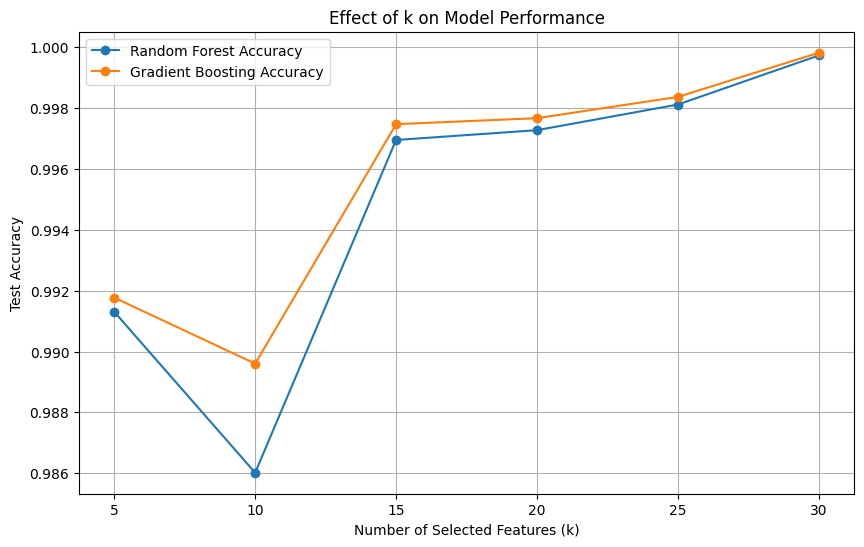

In [16]:
k_values = [5, 10, 15, 20, 25, 30]  # Range of k values to test
rf_accuracies = []
gb_accuracies = []

for k in k_values:
   
    C_train, _, selected_columns = cur_decomposition(X_Train, k)
    X_Train_reduced = X_Train[:, selected_columns]
    X_Test_reduced = X_Test[:, selected_columns]

    
    rf = RandomForestClassifier(n_estimators=1000, criterion='log_loss', max_depth=30, 
                                 max_features='sqrt', min_samples_leaf=1, min_samples_split=2, 
                                 n_jobs=-1, random_state=42)
    rf.fit(X_Train_reduced, Y_Train)
    Y_Pred = rf.predict(X_Test_reduced)
    rf_accuracies.append(accuracy_score(Y_Test, Y_Pred))
    

    GB_Model = GradientBoostingClassifier(n_estimators=1000, criterion='squared_error', 
                                          learning_rate=0.1, loss='log_loss', max_depth=10, 
                                          max_features='sqrt', min_samples_split=10, random_state=42)
    GB_Model.fit(X_Train_reduced, Y_Train)
    Y_Pred = GB_Model.predict(X_Test_reduced)
    gb_accuracies.append(accuracy_score(Y_Test, Y_Pred))

print(rf_accuracies)
print(gb_accuracies)

plt.figure(figsize=(10, 6))
plt.plot(k_values, rf_accuracies, label="Random Forest Accuracy", marker='o')
plt.plot(k_values, gb_accuracies, label="Gradient Boosting Accuracy", marker='o')
plt.title("Effect of k on Model Performance")
plt.xlabel("Number of Selected Features (k)")
plt.ylabel("Test Accuracy")
plt.legend()
plt.grid()
plt.show()